In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "12_generation/12e_image_captioning.ipynb"
_nb_title = "Image Captions"
_nb_message = """
This notebook shows you how to train an ML model to generate captions for images. The training dataset is the COCO large-scale object detection, segmentation, and captioning dataset.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Image+Captions&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F12_generation%2F12e_image_captioning.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/12_generation/12e_image_captioning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/12_generation/12e_image_captioning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/12_generation/12e_image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>Image Captions</h1>
This notebook shows you how to train an ML model to generate captions for images. The training dataset is the COCO large-scale object detection, segmentation, and captioning dataset.


## Enable GPU
This notebook and pretty much every other notebook in this repository will run faster if you are using a GPU. 

On Colab:
* Navigate to Edit→Notebook Settings
* Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
* Navigate to https://console.cloud.google.com/ai-platform/notebooks
* Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
# Not needed in Colab
%pip install --quiet tfds-nightly # In Nov 2020, coco_captions is available only in the nightly build
%pip uninstall -y h5py
%pip install --quiet 'h5py < 3.0.0' # https://github.com/tensorflow/tensorflow/issues/44467

Note: you may need to restart the kernel to use updated packages.
Found existing installation: h5py 2.10.0
Uninstalling h5py-2.10.0:
  Successfully uninstalled h5py-2.10.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.1.1
Found GPU at: /device:GPU:0


## Read and visualize dataset

We will use the TensorFlow datasets capability to read the [COCO captions](https://www.tensorflow.org/datasets/catalog/coco_captions) dataset.
This version contains images, bounding boxes, labels, and captions from COCO 2014, split into the subsets defined by Karpathy and Li (2015) and takes
care of some data quality issues with the original dataset (for example, some
of the images in the original dataset did not have captions)

**Note**: This dataset is too large to store in an ephemeral location.
Therefore, I'm storing the data in the GCS bucket corresponding to this book.
If you access it from a Notebook outside the US, it will be (a) slow and
(b) subject to a network charge.

In [3]:
GCS_DIR="gs://practical-ml-vision-book/tdfs_cache"

# Change these to control the accuracy/speed
VOCAB_SIZE = 5000 # use fewer words to speed up convergence
ATTN_UNITS = 512 # size of dense layer in Attention; larger more fine-grained
EPOCHS = 20 # train longer for greater accuracy
BATCH_SIZE = 64 # larger batch sizes lead to smoother convergence, but need more memory
EARLY_STOP_THRESH = 0.0001 # stop once loss improvement is less than this value
EMBED_DIM = 256 # embedding dimension for both images and words

# This is what Inception was trained with, so don't change unless you
# use a different pre-trained model. Inception takes (299, 299, 3) as
# input and provides (64, 2048) as output
IMG_HEIGHT = 299
IMG_WIDTH = 299
IMG_CHANNELS = 3
FEATURES_SHAPE = 2048
ATTN_FEATURES_SHAPE = 64

In [12]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

def filter_for_crowds(example):
    return (tf.math.count_nonzero(example['objects']['is_crowd']) > 0)

def get_image_label(example):
  captions = example['captions']['text'] # all the captions
  img_id = example['image/id']
  img = example['image']
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # inception size
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return {
        'image_tensor': img,
        'image_id': img_id,
        'captions': captions
  }

trainds = tfds.load('coco_captions',
                    split='train',
                    shuffle_files=False,
                    data_dir=GCS_DIR)

# reduce number of images in one of these ways
trainds = trainds.filter(filter_for_crowds)
#trainds = trainds.take(10000)

trainds = trainds.map(get_image_label)

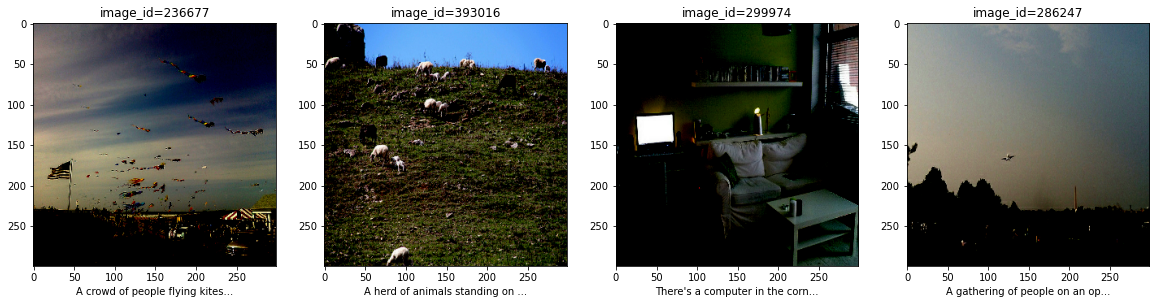

In [4]:
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
  ax[idx].imshow(data['image_tensor'].numpy())
  ax[idx].set_title('image_id={}'.format(data['image_id'].numpy()))
  ax[idx].set_xlabel(data['captions'].numpy()[0].decode('utf-8')[:30] + str("..."))

## Tokenize captions

Add a start and end token to each caption.
Then send to the Keras tokenizer which will lowercase the captions
and remove punctuation etc. It will also retain only the most frequent
words.

In [14]:
# get all the captions to feed into the Tokenizer
STOPWORDS = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than'}
def preprocess_caption(c):
    caption = "<start> {} <end>".format(c.decode('utf-8'))
    words = [word for word in caption.lower().split()
            if word not in STOPWORDS]
    return (' '.join(words))

train_captions = []
for data in trainds:
  str_captions = [preprocess_caption(c) for c in data['captions'].numpy()]
  train_captions.extend(str_captions)
print(train_captions[:5])

['<start> crowd people flying kites cloudy blue sky. <end>', '<start> large number kites flying sky <end>', '<start> sky full kites flown crowd. <end>', '<start> large group people flying series kites. <end>', '<start> people field kites flying air. <end>']


In [15]:
# Choose the most frequent words from the vocabulary
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# pads each vector to the max_length of the captions
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
max_caption_length = len(cap_vector[0])
print("max_caption_length={}".format(max_caption_length))
print(cap_vector[0])
print([tokenizer.index_word[idx] for idx in cap_vector[0]])

max_caption_length=34
[  2  18   4  21  22 350  72  89   3   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
['<start>', 'crowd', 'people', 'flying', 'kites', 'cloudy', 'blue', 'sky', '<end>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [16]:
def create_batched_ds(trainds, batchsize):
  # generator that does tokenization, padding on the caption strings
  # and yields img, caption
  def generate_image_captions():
    for data in trainds:
      captions = data['captions']
      img_tensor = data['image_tensor']
      str_captions = [preprocess_caption(c) for c in data['captions'].numpy()]
      seqs = tokenizer.texts_to_sequences(str_captions)
      # Pad each vector to the max_length of the captions
      padded = tf.keras.preprocessing.sequence.pad_sequences(
          seqs, padding='post', maxlen=max_caption_length)
      for caption in padded:
        yield img_tensor, caption # repeat image
  
  return tf.data.Dataset.from_generator(
      generate_image_captions,
      (tf.float32, tf.int32)).batch(batchsize)

for img, caption in create_batched_ds(trainds, 193).take(2):
    print(img.shape, caption.shape)
    print(caption[0])

(193, 299, 299, 3) (193, 34)
tf.Tensor(
[  2  18   4  21  22 350  72  89   3   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(34,), dtype=int32)
(193, 299, 299, 3) (193, 34)
tf.Tensor(
[   2   54  161    7   54 2741    3    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0], shape=(34,), dtype=int32)


## Create Captioning Model

It consists of an image encoder, followed by a caption decoder.
The caption decoder incorporates an attention mechanism that
focuses on different parts of the input image.

In [17]:
class ImageEncoder(tf.keras.Model):
   def __init__(self, embedding_dim):
     super(ImageEncoder, self).__init__()
     inception = tf.keras.applications.InceptionV3(
         include_top=False,
         weights='imagenet'
     )
     self.model = tf.keras.Model(inception.input,
                                 inception.layers[-1].output)
     self.fc = tf.keras.layers.Dense(embedding_dim)

   def call(self, x):
     x = self.model(x)
     x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
     x = self.fc(x)
     x = tf.nn.relu(x)
     return x

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CaptionDecoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(CaptionDecoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

encoder = ImageEncoder(EMBED_DIM)
decoder = CaptionDecoder(EMBED_DIM, ATTN_UNITS, VOCAB_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Training loop

Here, we use a custom training loop because we have to add on to the decoder
input (dec_input) one word at a time.

In [18]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [19]:
import time

batched_ds = create_batched_ds(trainds, BATCH_SIZE)

prev_loss = 999
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    num_steps = 0

    for batch, (img_tensor, target) in enumerate(batched_ds):
      batch_loss, t_loss = train_step(img_tensor, target)
      total_loss += t_loss
      num_steps += 1

      if batch % 100 == 0:
        print ('Epoch {} Batch {} Loss {:.4f}'.format(
            epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    current_loss = total_loss / num_steps
    
    # storing the epoch end loss value to plot later
    loss_plot.append(current_loss)

    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f} Time taken {:.1f} sec'.format(
        epoch + 1,
        current_loss,
        time.time() - start))
    
    # stop once it has converged
    improvement = prev_loss - current_loss
    if improvement < EARLY_STOP_THRESH:
        print("Stopping because improvement={} < {}".format(improvement, EARLY_STOP_THRESH))
        break
    prev_loss = current_loss

Epoch 1 Batch 0 Loss 1.7782
Epoch 1 Batch 100 Loss 1.2450
Epoch 1 Batch 200 Loss 1.2771
Epoch 1 Batch 300 Loss 1.1686
Epoch 1 Batch 400 Loss 1.3149
Epoch 1 Loss 1.251480 Time taken 540.5 sec
Epoch 2 Batch 0 Loss 1.2971
Epoch 2 Batch 100 Loss 1.2085
Epoch 2 Batch 200 Loss 1.2669
Epoch 2 Batch 300 Loss 1.1636
Epoch 2 Batch 400 Loss 1.3002
Epoch 2 Loss 1.231064 Time taken 453.0 sec
Epoch 3 Batch 0 Loss 1.2785
Epoch 3 Batch 100 Loss 1.2132
Epoch 3 Batch 200 Loss 1.2575
Epoch 3 Batch 300 Loss 1.1773
Epoch 3 Batch 400 Loss 1.2840
Epoch 3 Loss 1.224982 Time taken 452.8 sec
Epoch 4 Batch 0 Loss 1.2777
Epoch 4 Batch 100 Loss 1.2022
Epoch 4 Batch 200 Loss 1.2670
Epoch 4 Batch 300 Loss 1.1515
Epoch 4 Batch 400 Loss 1.2940
Epoch 4 Loss 1.222021 Time taken 452.2 sec
Epoch 5 Batch 0 Loss 1.2734
Epoch 5 Batch 100 Loss 1.2083
Epoch 5 Batch 200 Loss 1.2392
Epoch 5 Batch 300 Loss 1.1507
Epoch 5 Batch 400 Loss 1.2892
Epoch 5 Loss 1.218935 Time taken 452.1 sec
Epoch 6 Batch 0 Loss 1.2671
Epoch 6 Batch 100

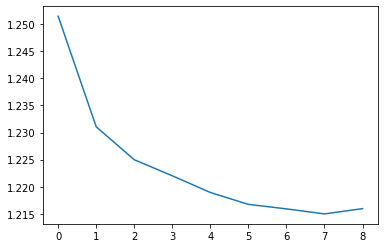

In [20]:
plt.plot(loss_plot);

## Prediction

To predict, we generate the caption one word at a time, feeding the
decoder with the previous predictions.

In [61]:
for id in range(10):
    print(id, tokenizer.index_word[id])

0 <pad>
1 <unk>
2 <start>
3 <end>
4 people
5 group
6 man
7 standing
8 baseball
9 street


['group', 'people', 'standing', 'field', '<end>']


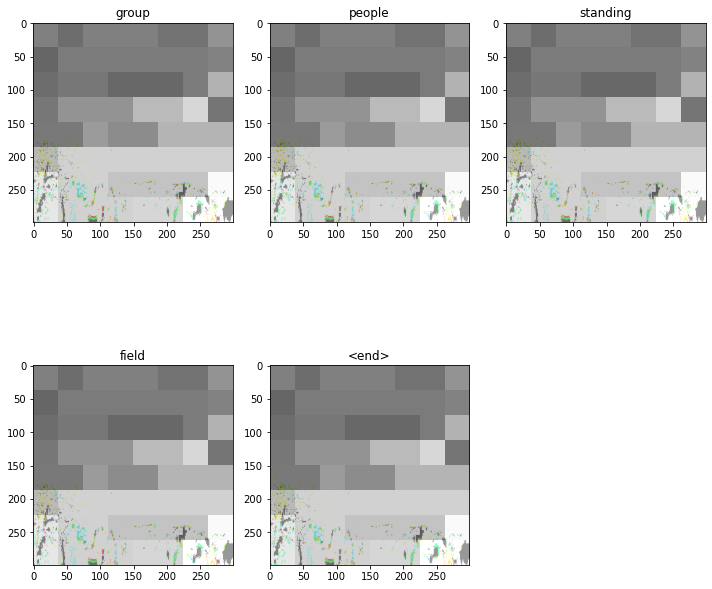

In [118]:
## Probabilistic prediction using the trained model
def plot_attention(image, result, attention_plot):
  fig = plt.figure(figsize=(10, 10))

  len_result = len(result)
  num_panels = len_result//2
  if num_panels*2 < len_result:
    num_panels += 1
  for l in range(len_result):
    temp_att = np.resize(attention_plot[l], (8, 8))
    ax = fig.add_subplot(len_result//2, num_panels, l+1)
    ax.set_title(result[l])
    img = ax.imshow(image)
    ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

  plt.tight_layout()
  plt.show()

def predict_caption(filename):
  attention_plot = np.zeros((max_caption_length, ATTN_FEATURES_SHAPE))
  hidden = decoder.reset_state(batch_size=1)
  img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH)) # inception size
  img_tensor_val = tf.keras.applications.inception_v3.preprocess_input(img)

  features = encoder(tf.expand_dims(img_tensor_val, axis=0))
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
  result = []
  previous_word_ids = []
  for i in range(max_caption_length):
    predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
    attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

    if i < 10:
        # mask out <pad> <unk> <start> <end>, since we don't want <end>
        masked_predictions = predictions[0]
        mask = [0.0, 0, 0, 0] + [1.0] * (masked_predictions.shape[0] - 4)
        # end is okay after 4th word
        if i > 3:
            mask[3] = 1
        # avoid repeating words
        for p in previous_word_ids:
          mask[p] = 0
        mask = tf.convert_to_tensor(mask)
        masked_predictions *= mask
        # keep only the top (i+2) words, and draw out of log distribution
        top_probs, top_idxs = tf.math.top_k(input=masked_predictions, k=(i+2), sorted=False)
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]
    else:
        # draws from log distribution given by predictions
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
    result.append(tokenizer.index_word[predicted_id])
    previous_word_ids.append(predicted_id)
    
    if tokenizer.index_word[predicted_id] == '<end>':
      return img, result, attention_plot

    dec_input = tf.expand_dims([predicted_id], 0)
  
  attention_plot = attention_plot[:len(result), :]
  return img, result, attention_plot

# image from https://commons.wikimedia.org/wiki/File:Flying_Kites_At_Sunset.jpg
filename = "gs://practical-ml-vision-book/images/800px-Flying_Kites_At_Sunset.jpg"
image, caption, attention_plot = predict_caption(filename)
print(caption)
plot_attention(image, caption, attention_plot)

The model has managed to capture the key aspects of the image:
<pre>
group of people standing in a field.
</pre>
However, the model hasn't quite figured out the attention (note the attention is similar throughout).

## Plots for book

In [22]:
print(encoder.summary())

Model: "image_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, None, None, 2048)  21802784  
_________________________________________________________________
dense (Dense)                multiple                  524544    
Total params: 22,327,328
Trainable params: 22,292,896
Non-trainable params: 34,432
_________________________________________________________________
None


In [23]:
print(decoder.summary())

Model: "caption_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1280000   
_________________________________________________________________
gru (GRU)                    multiple                  1575936   
_________________________________________________________________
dense_1 (Dense)              multiple                  262656    
_________________________________________________________________
dense_2 (Dense)              multiple                  2565000   
_________________________________________________________________
bahdanau_attention (Bahdanau multiple                  394753    
Total params: 6,078,345
Trainable params: 6,078,345
Non-trainable params: 0
_________________________________________________________________
None


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.